# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Final Project: Trumps Tweets

**Group Members**: Sarah Chin, Maleah Fekete, Mason Watson, Jasper Fu

In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from sklearn import tree
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

In [3]:
trump_tweets = pd.read_csv("trump_tweet.csv")

In [4]:
trump_tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,It was my great honor to deliver the keynote a...,10-25-2019 19:51:43,5132.0,16938,false,1.187819e+18
1,Twitter for iPhone,Thank you @robertjeffress! https://t.co/o6mk8o...,10-25-2019 17:57:25,6095.0,22287,false,1.187790e+18
2,Twitter for iPhone,RT @GaryCoby: Today @realDonaldTrump is receiv...,10-25-2019 17:35:13,5810.0,0,true,1.187785e+18
3,Twitter for iPhone,Heading to South Carolina! https://t.co/CORtaP...,10-25-2019 17:30:21,8900.0,40776,false,1.187783e+18
4,Twitter for iPhone,RT @gatewaypundit: Breaking Poll: 52% Say Impe...,10-25-2019 16:22:09,7649.0,0,true,1.187766e+18


In [5]:
# Drop this entry because it provides no information under the analyses we are currently performing
trump_tweets = trump_tweets[~trump_tweets.text.isnull()]

In [6]:
display(trump_tweets[trump_tweets.retweet_count.isnull()])
display(trump_tweets[trump_tweets.favorite_count.isnull()])
display(trump_tweets[trump_tweets.created_at.isnull()])
display(trump_tweets[trump_tweets.id_str.isnull()])

# The entries with null retweet_count are the same as the entries will null favorite_count and null created_at
# These are also included in the entries with null id_str 
# We will group all of these into a separate dataframe to deal with null entries

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
38571,TweetDeck,My interview which recently aired on CNBC's Sq...,NaN,NaN,NaN,NaN,NaN
38695,TweetDeck,http://goo.gl/AMNEE Countdown to @AmericaNowRa...,NaN,NaN,NaN,NaN,NaN
38719,TweetDeck,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
38571,TweetDeck,My interview which recently aired on CNBC's Sq...,NaN,NaN,NaN,NaN,NaN
38695,TweetDeck,http://goo.gl/AMNEE Countdown to @AmericaNowRa...,NaN,NaN,NaN,NaN,NaN
38719,TweetDeck,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
38571,TweetDeck,My interview which recently aired on CNBC's Sq...,NaN,NaN,NaN,NaN,NaN
38695,TweetDeck,http://goo.gl/AMNEE Countdown to @AmericaNowRa...,NaN,NaN,NaN,NaN,NaN
38719,TweetDeck,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
38571,TweetDeck,My interview which recently aired on CNBC's Sq...,NaN,NaN,NaN,NaN,NaN
38572,My in… (cont) http://t.co/YNX1msYh,09-19-2011 17:54:28,18,7.0,false,115846232714391552,NaN
38695,TweetDeck,http://goo.gl/AMNEE Countdown to @AmericaNowRa...,NaN,NaN,NaN,NaN,NaN
38696,#Apprentice Andy and I talk about politics an…...,08-09-2011 19:33:31,20,3.0,false,101013255950053376,NaN
38719,TweetDeck,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN
38721,My interview yesterday on CNBC's Squawk Box...,08-02-2011 19:56:31,13,12.0,false,98482327390396416,NaN


In [7]:
# Create new dataframe with null values
trump_tweets_nulls = trump_tweets[trump_tweets.id_str.isnull()]

# Drop indices with a lot of null entries from the main dataframe
trump_tweets_main = trump_tweets[~trump_tweets.id_str.isnull()]

# Check. These should all display an empty dataframe
display(trump_tweets_main[trump_tweets_main.retweet_count.isnull()])
display(trump_tweets_main[trump_tweets_main.favorite_count.isnull()])
display(trump_tweets_main[trump_tweets_main.created_at.isnull()])
display(trump_tweets_main[trump_tweets_main.id_str.isnull()])

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str


In [8]:
display(trump_tweets[trump_tweets.id_str.isnull() == True])

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
38571,TweetDeck,My interview which recently aired on CNBC's Sq...,NaN,NaN,NaN,NaN,NaN
38572,My in… (cont) http://t.co/YNX1msYh,09-19-2011 17:54:28,18,7.0,false,115846232714391552,NaN
38695,TweetDeck,http://goo.gl/AMNEE Countdown to @AmericaNowRa...,NaN,NaN,NaN,NaN,NaN
38696,#Apprentice Andy and I talk about politics an…...,08-09-2011 19:33:31,20,3.0,false,101013255950053376,NaN
38719,TweetDeck,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN
38721,My interview yesterday on CNBC's Squawk Box...,08-02-2011 19:56:31,13,12.0,false,98482327390396416,NaN


Just for this EDA we will ignore the 3 columns with all null non-text entries and the 3 columns where the categories got mixed up. We will only use data_main.

In [9]:
trump_tweets_main.dtypes

source             object
text               object
created_at         object
retweet_count     float64
favorite_count     object
is_retweet         object
id_str            float64
dtype: object

We notice that favorite_count is an object instead of an number, so we need to convert it before continuing with EDA. We will also change created_at to a DateTime object

In [10]:
trump_tweets_main.is_retweet.shape

(39087,)

In [11]:
print(trump_tweets_main[trump_tweets_main['is_retweet'] == 'true'].shape)
print(trump_tweets_main[trump_tweets_main['is_retweet'] == 'false'].shape)

(2761, 7)
(36268, 7)


In [12]:
trump_tweets_main[(trump_tweets_main['is_retweet'] != 'true') & (trump_tweets_main['is_retweet'] != 'false')].head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
9063,Twitter for iPhone,Thanks to all of the Republican and Democratic...,01-09-2018 22:51:50,11718.0,58068,NaN,9.508627e+17
9064,Twitter for iPhone,It was my great honor to sign H.R. 267 the “Ma...,01-09-2018 20:17:17,17249.0,73554,NaN,9.508238e+17
9065,Twitter for iPhone,On behalf of the American people THANK YOU to ...,01-09-2018 17:11:23,26793.0,112613,NaN,9.507770e+17
9066,Twitter for iPhone,We are fighting for our farmers for our countr...,01-08-2018 23:19:47,22044.0,104968,NaN,9.505074e+17
9067,Twitter for iPhone,In every decision we make we are honoring Amer...,01-08-2018 22:59:37,17769.0,81027,NaN,9.505023e+17


Looking at the first of these on the actual platform, it is not a retweet, but will need to do more probabilistic analysis to say with certainty. It does not make sense to just drop these rows as they were all created in a similar time frame so this could skew results.

In [13]:
trump_tweets_main["created_at"] = pd.to_datetime(trump_tweets_main['created_at'], errors='coerce')
trump_tweets_main["favorite_count"] = pd.to_numeric(trump_tweets_main["favorite_count"])

scaler = MinMaxScaler()
trump_tweets_main[['favorite_count', 'retweet_count']] = scaler.fit_transform(trump_tweets_main[['favorite_count', 'retweet_count']])

trump_tweets_main["fbyr"] = np.log(trump_tweets_main["favorite_count"] / trump_tweets_main["retweet_count"])

trump_tweets_main.dtypes

/Users/mkw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mkw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mkw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

source                    object
text                      object
created_at        datetime64[ns]
retweet_count            float64
favorite_count           float64
is_retweet                object
id_str                   float64
fbyr                     float64
dtype: object

In [14]:
trump_retweets = trump_tweets_main[trump_tweets_main.is_retweet == 'true']
trump_not_retweets = trump_tweets_main[trump_tweets_main.is_retweet == 'false']

In [15]:
trump_retweets.describe()

/Users/mkw/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,retweet_count,favorite_count,id_str,fbyr
count,2761.000000,2761.0,2.761000e+03,2761.0
mean,0.032394,0.0,1.074495e+18,-inf
std,0.029412,0.0,1.230205e+17,NaN
min,0.000008,0.0,6.834997e+17,-inf
25%,0.016091,0.0,1.025582e+18,NaN
50%,0.024902,0.0,1.124647e+18,NaN
75%,0.039006,0.0,1.164750e+18,NaN
max,0.568752,0.0,1.187785e+18,-inf


In [16]:
trump_not_retweets.describe()

,retweet_count,favorite_count,id_str,fbyr
count,36268.000000,36268.000000,3.626800e+04,3.567000e+04
mean,0.016553,0.027646,6.135054e+17,NaN
std,0.029703,0.049113,2.957128e+17,NaN
min,0.000000,0.000000,1.698309e+09,-inf
25%,0.000060,0.000033,3.625925e+17,-8.843989e-01
50%,0.000869,0.000290,5.698976e+17,1.527586e-04
75%,0.027495,0.043095,8.162992e+17,4.844336e-01
max,1.000000,1.000000,1.187819e+18,inf


We create these for use in future analyses

/Users/mkw/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


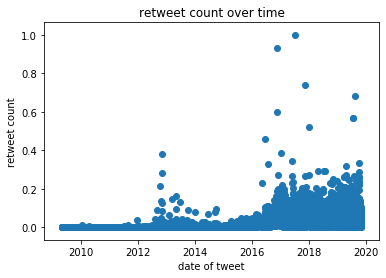

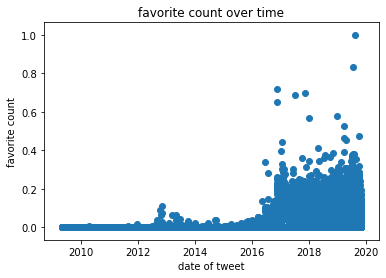

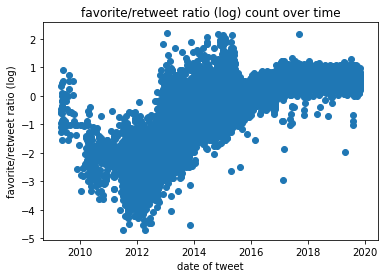

In [17]:
plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["retweet_count"])
plt.xlabel("date of tweet")
plt.ylabel("retweet count")
plt.title("retweet count over time")
plt.show()

plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["favorite_count"])
plt.xlabel("date of tweet")
plt.ylabel("favorite count")
plt.title("favorite count over time")
plt.show()

plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["fbyr"], )
plt.ylabel("favorite/retweet ratio (log)")
plt.xlabel("date of tweet")
plt.title("favorite/retweet ratio (log) count over time")
plt.show()

In [18]:
text = trump_tweets['text']

In [19]:
np.savetxt('tweet_txt.txt', text.values, fmt='%s')

In [20]:
!pip install gensim nltk

In [21]:
import nltk
import gensim 
from gensim.models import Word2Vec

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mkw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
# Replaces escape character with space 
sample = open("tweet_txt.txt", "r") 
s = sample.read() 
f = s.replace("\n", " ") 
  
data = [] 
  
# iterate through each sentence in the file 
for i in nltk.sent_tokenize(f): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in nltk.word_tokenize(i): 
        temp.append(j.lower()) 
  
    data.append(temp) 
  
# Create CBOW model 
model1 = gensim.models.Word2Vec(data, min_count = 1,  
                              size = 100, window = 5)  

In [23]:
#100 rarest words
model1.wv.index2entity[-100:]

['mod=wsj_ny_realestate_middle_lsmini',
 '//www.missuniverse.com/missusa',
 '//www.newyorksightseeing.com/',
 '//www.trumpnationalwestchester.com/',
 'geomorphology',
 'landforms',
 '//bit.ly/ckmkku',
 '//ow.ly/1nfmt',
 'jewlery',
 'comedic',
 'mother-daughter',
 'adkins',
 'theatrical',
 'ref',
 'onthursday',
 'estefan',
 'bettis',
 'steelers',
 'club/palm',
 'erving',
 "'dr",
 'p.m.et',
 '//www.trump.com/',
 'connery',
 '2..',
 'thisthursday',
 'nbc.com/casting',
 '//tinyurl.com/yly2c8u',
 'theoriginal',
 'fanastic',
 'two-hour',
 'bocelli',
 '//bit.ly/2fngoz',
 '//bit.ly/cv1en7',
 'connector',
 '//bit.ly/bpip7t',
 '1/25',
 'wahlberg',
 'dillon',
 '//bit.ly/4mubn6',
 '2.99',
 '//bit.ly/uguf0',
 '3/14',
 '9-11pm',
 'et/pt',
 'habitat',
 '//bit.ly/sqvqq',
 'bountiful',
 'tv1',
 '//tinyurl.com/yk5m3lc',
 'w/neil',
 '//tinyurl.com/yhnzd7p',
 '//tinyurl.com/yk6hlfo',
 '//tinyurl.com/ycsqmda',
 '//tinyurl.com/mcn8yl',
 'hysterical',
 'dsrl',
 'lick',
 'sweepstakes',
 '//tinyurl.com/6asujj'

In [24]:
#100 most common words
model1.wv.index2entity[:100]

['@',
 '.',
 'the',
 ':',
 '!',
 'to',
 'and',
 'a',
 'of',
 'is',
 'for',
 'in',
 'you',
 'i',
 'realdonaldtrump',
 '#',
 'on',
 'be',
 'https',
 'it',
 'will',
 'great',
 'that',
 ',',
 'trump',
 'are',
 'with',
 '’',
 'we',
 'http',
 'have',
 ';',
 'our',
 '&',
 'amp',
 'at',
 'he',
 "'s",
 '?',
 'this',
 '...',
 'my',
 'not',
 'they',
 'was',
 "''",
 '-',
 'all',
 'president',
 'twitter',
 'do',
 'has',
 'rt',
 '“',
 'by',
 '”',
 'thank',
 'so',
 "n't",
 'your',
 'just',
 'people',
 'as',
 's',
 'very',
 ')',
 'from',
 '(',
 'no',
 'who',
 'thanks',
 '--',
 'what',
 'but',
 'his',
 'can',
 'me',
 'would',
 'now',
 'if',
 'country',
 'america',
 'new',
 'get',
 'about',
 'donald',
 'more',
 'out',
 'obama',
 'android',
 'like',
 'should',
 'an',
 't',
 'time',
 'big',
 'good',
 'one',
 'make',
 'up']

In [25]:
print(model1.wv.most_similar(positive=['government', 'immigrants'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['government'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['maga'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['hillary'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['mueller'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['russia'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['fox', 'real'], topn=5))
print("\n")
print(model1.wv.most_similar(positive=['fake','cnn'], topn=5))


[('syria', 0.9287018775939941), ('terrorists', 0.9144769906997681), ('terrorism', 0.9078233242034912), ('isis', 0.9034658670425415), ('reserve', 0.9023773670196533)]


[('system', 0.8685330152511597), ('power', 0.8641236424446106), ('reserve', 0.8610947132110596), ('syria', 0.8582416772842407), ('steal', 0.8528667688369751)]


[('americafirst', 0.9527989625930786), ('makeamericagreatagain', 0.9515604972839355), ('trumpforpresident', 0.9496332406997681), ('trump16', 0.939717710018158), ('caucusfortrump', 0.9385370016098022)]


[('clinton', 0.9286983013153076), ('crooked', 0.9257874488830566), ('mueller', 0.8854689598083496), ('fbi', 0.871028482913971), ('romney', 0.8663819432258606)]


[('fbi', 0.9160300493240356), ('report', 0.9152013063430786), ('bernie', 0.8912571668624878), ('cruz', 0.8910859227180481), ('crooked', 0.8891814351081848)]


[('mueller', 0.8711605668067932), ('investigation', 0.8685417175292969), ('russian', 0.8625145554542542), ('russians', 0.8607251644134521), ('collu